In [8]:
%matplotlib inline

# On importe les librairies dont on aura besoin pour ce tp
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import itertools

from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix

# Pour ne pas avoir les warnings lors de la compilation
warnings.filterwarnings("ignore")

In [9]:
# Lieu où se trouve le fichier
_DOSSIER = 'C:\\Users\\Toni\\Desktop\\pas_synchro\\p5\\'
_FICHIERDATA = _DOSSIER + 'dataset_p5.csv'
_VERBOSE = 0

# Fonctions utilisées

In [10]:
def plot_confusion_matrix(cm, classes, title, biais):
    """
    Cette fonction crée un plot à partir d'une matrice de confusion.
    """

    # Taille de la figure
    np.set_printoptions(precision=2)
    plt.figure(figsize=(7, 7))

    # Jeu de couleur
    cmap = plt.cm.Greens

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    title = "Matrix_" + biais + "_"  + title
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def appel_cvs(xtrain, xtest, ytrain, ytest, biais):
    """
    Fonction qui fournit les hyperparamètres aux modèles et appelle les fonctions
    """

    # Choix de l'algorithme de classification
    model = [KNeighborsClassifier(),
             AdaBoostClassifier(),
             RandomForestClassifier(),
             GradientBoostingClassifier()
            ]

    # Hyperparamètres
    param_grid = [{'n_neighbors': [5, 9, 13, 17, 23, 29, 37, 43, 50]},
                  {'n_estimators': [5, 20, 35, 50, 65]},
                  {'max_depth': [None, 10, 20, 30], 'n_estimators': [5, 20, 35, 50]},
                  {'max_depth': [None, 10, 20, 30], 'n_estimators': [5, 20, 35, 50]}
                 ]

    # Appel de fonction avec le classifieur
    for i in range(0, len(model)):
        log_cv = algos_cv(xtrain, xtest, ytrain, ytest, model[i], param_grid[i], biais)

def algos_cv(xtrain, xtest, ytrain, ytest, model, param_grid, biais):
    """
    Cette fonction effectue une gridsearch et affichage les résultats
    """

    # Score à améliorer
    score = 'accuracy'

    print(model.__class__.__name__, "\n")

    # Options de l'algorithme
    clf = GridSearchCV(model,
                       param_grid=param_grid,
                       verbose=_VERBOSE,
                       cv=5,
                       scoring=score,
                       refit=True,
                       return_train_score=False)

    # Fit
    clf.fit(xtrain, ytrain)

    # Liste qui va garder les résultats
    log_cols = ["Accuracy", "Hyperparametres"]
    log_cv = pd.DataFrame(columns=log_cols)

    # Affichages
    for score, params in zip(clf.cv_results_['mean_test_score'], clf.cv_results_['params']):
        print("Score : ", round(score*100, 2), "pour", params)

        # Sauvegarde des scores de predictions
        log_entry = pd.DataFrame([[round(score*100, 2), params]], columns=log_cv.columns)
        log_cv = log_cv.append(log_entry)

    # Meilleurs paramètres
    score_max = round(clf.best_score_*100, 2)
    print("Meilleur score : ", score_max, "pour", clf.best_params_, "\n")

    # Affichage du diagramme en baton
    affichage_score(model, log_cv, biais)

    ypred = clf.best_estimator_.predict(xtest)

    # Affichage de la matrice de confusion
    cnf_matrix = confusion_matrix(ytest, ypred)
    plot_confusion_matrix(cnf_matrix, ytest.unique(), model.__class__.__name__, biais)

    return log_cv

def affichage_score(model, log_cv, biais):
    """
    Diagrammes en batons pour voir les résultats
    """

    # Mise en forme légère
    log_cv = log_cv.reset_index()
    del log_cv['index']

    # Noms des variables
    data_colonne = log_cv['Accuracy']
    data_ligne = log_cv['Hyperparametres']

    # La figure change de taille suivant le nombre de données
    plt.figure(figsize=(len(data_colonne), 8))

    # Données de l'axe X
    x_axis = [k for k, i in enumerate(data_colonne)]
    x_label = [i for i in data_ligne]

    # Données de l'axe Y
    y_axis = [i for i in data_colonne]

    # Limite de l'axe Y
    plt.ylim(min(log_cv['Accuracy'])-0.5, max(log_cv['Accuracy'])+0.5)

    # Largeur des barres
    width = 0.2

    # Légende de l'axe X
    plt.xticks(x_axis, x_label, rotation=90)

    # Création
    rects = plt.bar(x_axis, y_axis, width, color='b')

    # On fait les labels pour les afficher
    labels = ["%.2f" % i for i in data_colonne]

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        width = rect.get_width()

        plt.text(rect.get_x()+ width/2, height + 0.1, label, ha='center', va='bottom')

    # Barres horizontales
    plt.axhline(y=sum(data_colonne)/len(data_colonne), color='r', linestyle='-')
    plt.axhline(y=min(data_colonne), color='g', linestyle='-')

    # Esthétisme
    plt.grid()
    plt.ylabel('Accuracy')
    titre = 'Accuracy pour ' + model.__class__.__name__ + ", " + "biais = " + biais
    plt.title(titre)
    plt.tight_layout()
    plt.show()

def algo_wo_optimisation(xtrain, xtest, ytrain, ytest):
    """
    Tests de différentes algorithems sans optimisation recherchée
    Uniquement pour avoir une petite idée de ce qu'ils sont capables de faire
    """

    classifiers = [KNeighborsClassifier(3),
                   RandomForestClassifier(),
                   AdaBoostClassifier(),
                   GradientBoostingClassifier(),
                  ]

    # Logging for Visual Comparison
    log_cols = ["Classifier", "Accuracy", "Log Loss"]
    log = pd.DataFrame(columns=log_cols)

    for clf in classifiers:
        clf.fit(xtrain, ytrain)
        name = clf.__class__.__name__

        # Affichage
        print("="*30)
        print(name)
        print('****Resultats****')

        # Scores des prédictions
        train_predictions = clf.predict(xtest)
        acc = accuracy_score(ytest, train_predictions)
        print("Accuracy: {:.4%}".format(acc))

        # Scores des prédictions
        train_predictions = clf.predict_proba(xtest)
        logloss = log_loss(ytest, train_predictions)
        print("Log Loss: {}".format(logloss))

        log_entry = pd.DataFrame([[name, acc*100, logloss]], columns=log_cols)
        log = log.append(log_entry)

    print("="*30)

    # Graphiques de comparaison
    sns.set_color_codes("muted")
    sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

    plt.xlabel('Accuracy %')
    plt.title('Classifier Accuracy')
    plt.show()

    sns.set_color_codes("muted")
    sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

    plt.xlabel('Log Loss')
    plt.title('Classifier Log Loss')
    plt.show()

# Fonction principale 

Lecture du dataset et séparation des données et des labels

In [11]:
# Lecture du dataset
data = pd.read_csv(_FICHIERDATA, error_bad_lines=False)

# Récupération de l'index
data = data.set_index('Unnamed: 0')

# Axe X
data_x = data.copy()

# On supprime les étiquettes de l'axe X
del data_x['labels']

# Axe Y = étiquettes
data_y = data['labels']

Trois essais vont être fait :
* Répartition Train/Test normale
* Répartition via un biais temporel
* Réparition avec data leakage

## Répartition Train/Test normale

KNeighborsClassifier
****Resultats****
Accuracy: 35.5996%
Log Loss: 13.398217730962646
RandomForestClassifier
****Resultats****
Accuracy: 94.8064%
Log Loss: 0.38261892489297145
AdaBoostClassifier
****Resultats****
Accuracy: 47.3088%
Log Loss: 1.7410493023659956
GradientBoostingClassifier
****Resultats****
Accuracy: 96.5061%
Log Loss: 0.12945405120567563


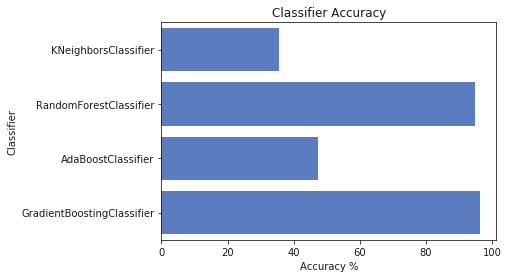

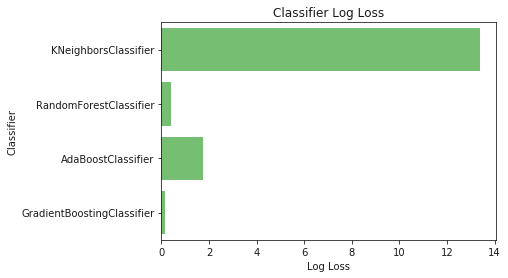

KNeighborsClassifier 

Score :  35.47 pour {'n_neighbors': 5}
Score :  37.83 pour {'n_neighbors': 9}
Score :  39.06 pour {'n_neighbors': 13}
Score :  38.15 pour {'n_neighbors': 17}
Score :  38.34 pour {'n_neighbors': 23}
Score :  38.18 pour {'n_neighbors': 29}
Score :  38.09 pour {'n_neighbors': 37}
Score :  37.87 pour {'n_neighbors': 43}
Score :  37.96 pour {'n_neighbors': 50}
Meilleur score :  39.06 pour {'n_neighbors': 13} 



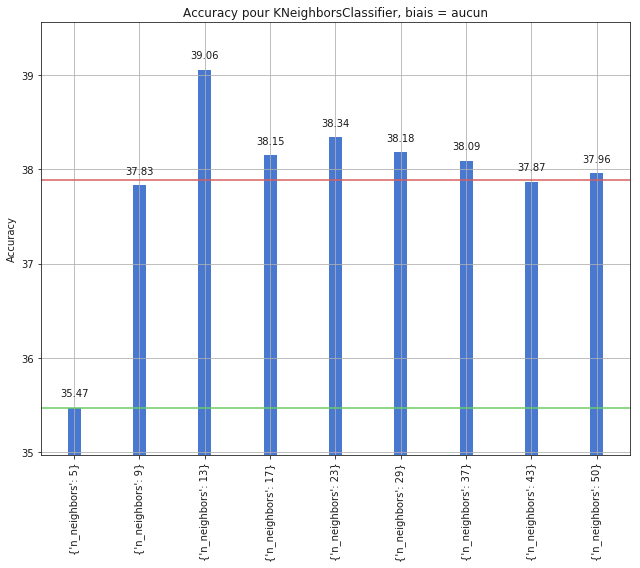

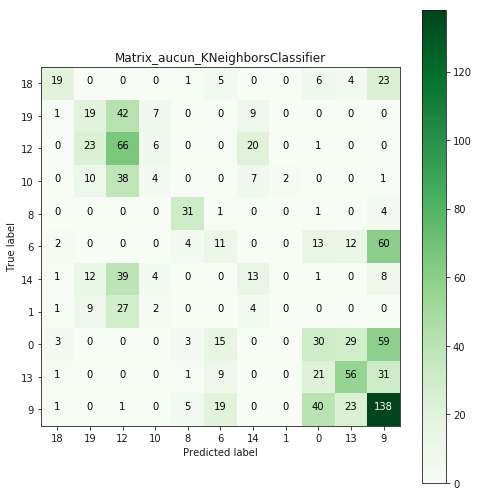

AdaBoostClassifier 

Score :  40.16 pour {'n_estimators': 5}
Score :  40.45 pour {'n_estimators': 20}
Score :  39.31 pour {'n_estimators': 35}
Score :  40.54 pour {'n_estimators': 50}
Score :  39.41 pour {'n_estimators': 65}
Meilleur score :  40.54 pour {'n_estimators': 50} 



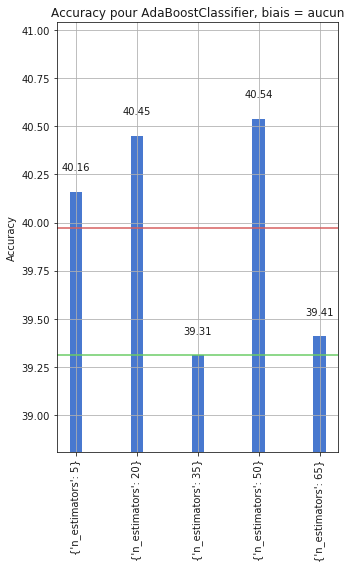

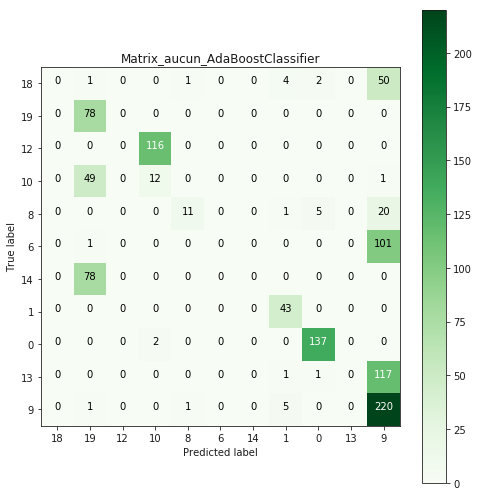

RandomForestClassifier 

Score :  93.7 pour {'max_depth': None, 'n_estimators': 5}
Score :  95.22 pour {'max_depth': None, 'n_estimators': 20}
Score :  95.72 pour {'max_depth': None, 'n_estimators': 35}
Score :  95.85 pour {'max_depth': None, 'n_estimators': 50}
Score :  94.05 pour {'max_depth': 10, 'n_estimators': 5}
Score :  95.5 pour {'max_depth': 10, 'n_estimators': 20}
Score :  95.44 pour {'max_depth': 10, 'n_estimators': 35}
Score :  95.53 pour {'max_depth': 10, 'n_estimators': 50}
Score :  93.8 pour {'max_depth': 20, 'n_estimators': 5}
Score :  95.37 pour {'max_depth': 20, 'n_estimators': 20}
Score :  95.37 pour {'max_depth': 20, 'n_estimators': 35}
Score :  95.75 pour {'max_depth': 20, 'n_estimators': 50}
Score :  94.49 pour {'max_depth': 30, 'n_estimators': 5}
Score :  96.1 pour {'max_depth': 30, 'n_estimators': 20}
Score :  95.59 pour {'max_depth': 30, 'n_estimators': 35}
Score :  95.91 pour {'max_depth': 30, 'n_estimators': 50}
Meilleur score :  96.1 pour {'max_depth': 30, '

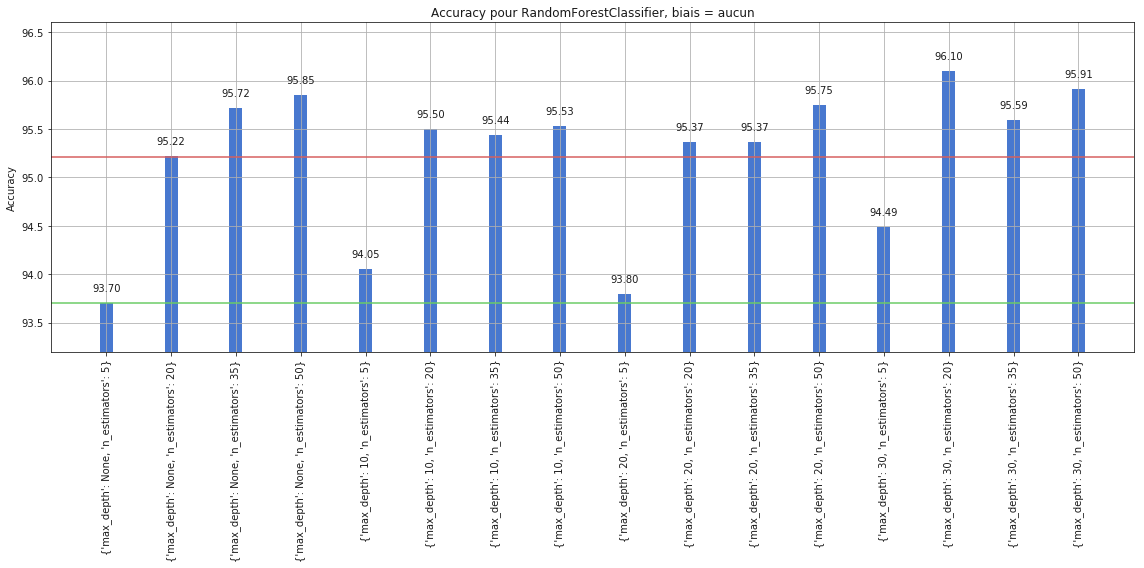

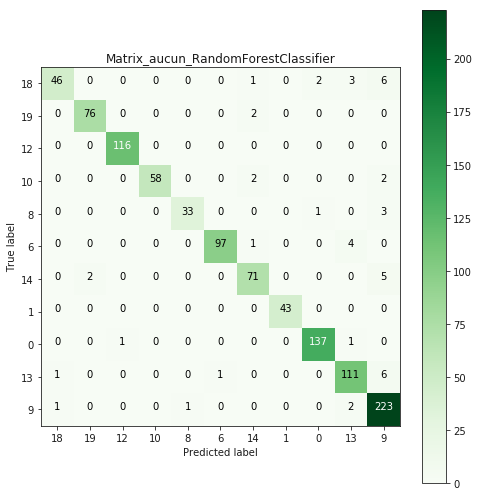

GradientBoostingClassifier 

Score :  95.22 pour {'max_depth': None, 'n_estimators': 5}
Score :  95.22 pour {'max_depth': None, 'n_estimators': 20}
Score :  95.53 pour {'max_depth': None, 'n_estimators': 35}
Score :  95.81 pour {'max_depth': None, 'n_estimators': 50}
Score :  95.06 pour {'max_depth': 10, 'n_estimators': 5}
Score :  95.44 pour {'max_depth': 10, 'n_estimators': 20}
Score :  95.62 pour {'max_depth': 10, 'n_estimators': 35}
Score :  96.0 pour {'max_depth': 10, 'n_estimators': 50}
Score :  95.34 pour {'max_depth': 20, 'n_estimators': 5}
Score :  95.22 pour {'max_depth': 20, 'n_estimators': 20}
Score :  95.59 pour {'max_depth': 20, 'n_estimators': 35}
Score :  95.94 pour {'max_depth': 20, 'n_estimators': 50}
Score :  95.09 pour {'max_depth': 30, 'n_estimators': 5}
Score :  95.25 pour {'max_depth': 30, 'n_estimators': 20}
Score :  95.62 pour {'max_depth': 30, 'n_estimators': 35}
Score :  95.91 pour {'max_depth': 30, 'n_estimators': 50}
Meilleur score :  96.0 pour {'max_depth'

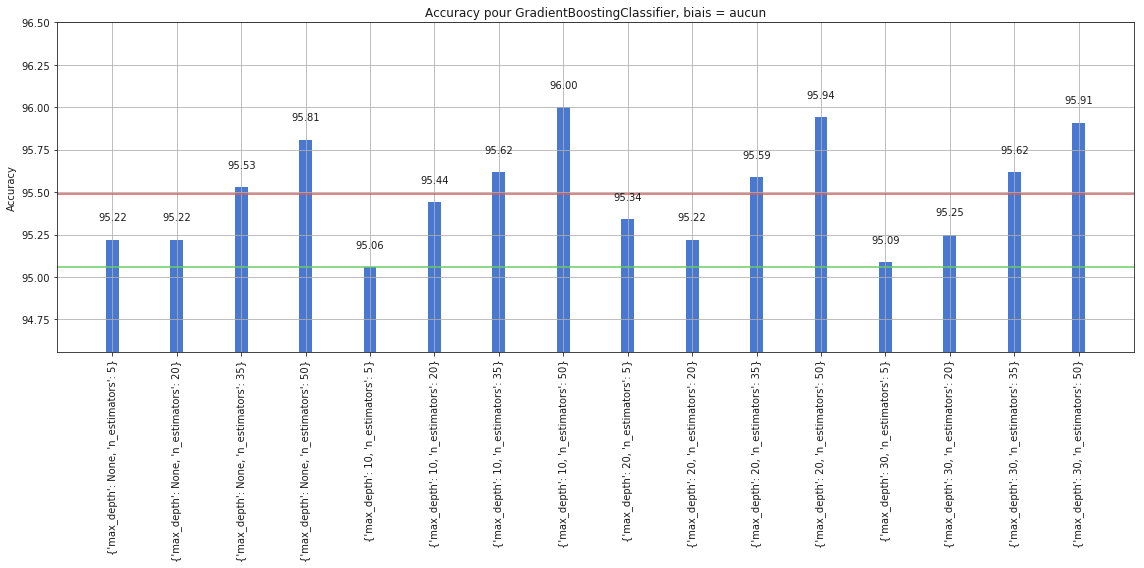

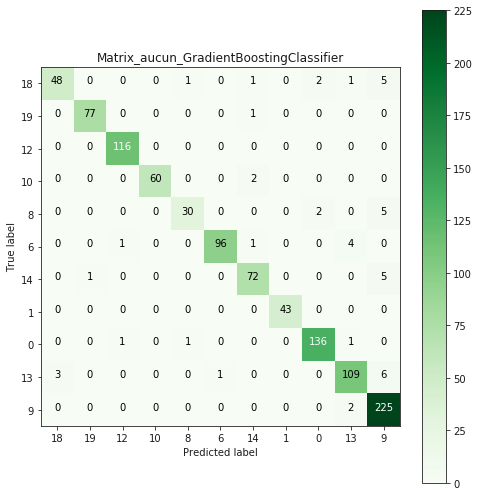

In [12]:
# Essai dans biais dans les données
# Répartition Train/Test
xtrain, xtest, ytrain, ytest = train_test_split(data_x, data_y, train_size=0.75, stratify=data_y)

# Sans optimisations
algo_wo_optimisation(xtrain, xtest, ytrain, ytest)

# Recherche d'optimisation
appel_cvs(xtrain, xtest, ytrain, ytest, "aucun")


## Répartition via un biais temporel. 

On ne garde que les achats qui sont fait le lundi et le mardi pour le dataset de test, et tous les autres jours de la semaine pour le dataset de train.

KNeighborsClassifier 

Score :  35.7 pour {'n_neighbors': 5}
Score :  36.2 pour {'n_neighbors': 9}
Score :  37.47 pour {'n_neighbors': 13}
Score :  38.35 pour {'n_neighbors': 17}
Score :  38.26 pour {'n_neighbors': 23}
Score :  37.79 pour {'n_neighbors': 29}
Score :  38.0 pour {'n_neighbors': 37}
Score :  38.15 pour {'n_neighbors': 43}
Score :  38.35 pour {'n_neighbors': 50}
Meilleur score :  38.35 pour {'n_neighbors': 17} 



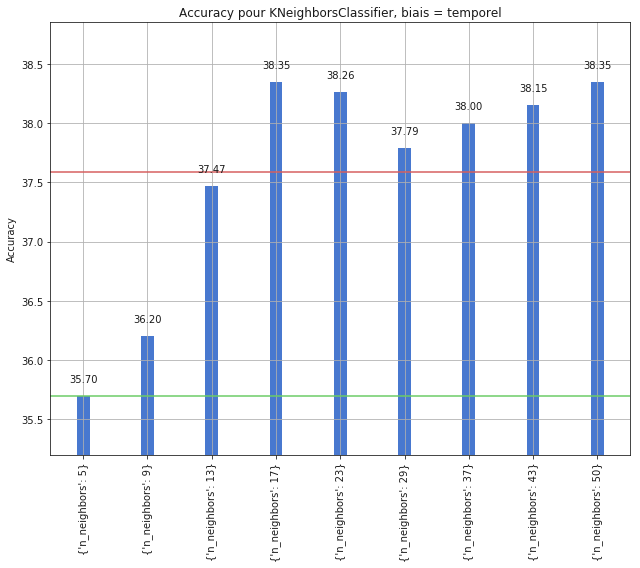

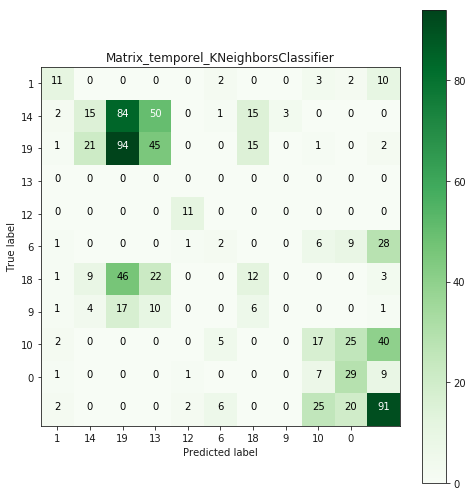

AdaBoostClassifier 

Score :  44.2 pour {'n_estimators': 5}
Score :  42.07 pour {'n_estimators': 20}
Score :  41.81 pour {'n_estimators': 35}
Score :  42.07 pour {'n_estimators': 50}
Score :  41.81 pour {'n_estimators': 65}
Meilleur score :  44.2 pour {'n_estimators': 5} 



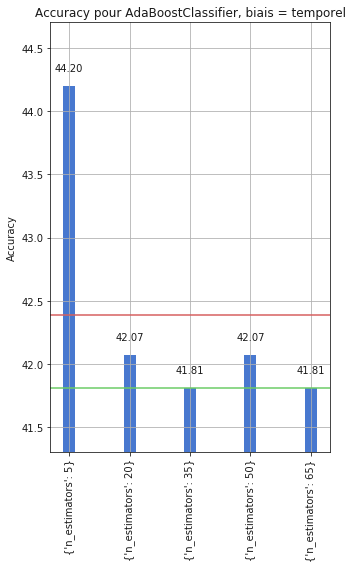

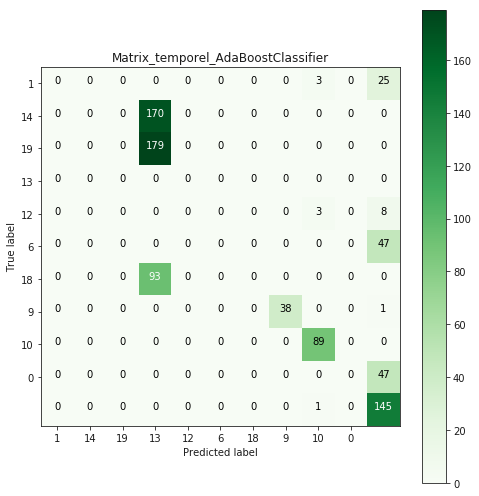

RandomForestClassifier 

Score :  94.48 pour {'max_depth': None, 'n_estimators': 5}
Score :  95.78 pour {'max_depth': None, 'n_estimators': 20}
Score :  95.75 pour {'max_depth': None, 'n_estimators': 35}
Score :  96.1 pour {'max_depth': None, 'n_estimators': 50}
Score :  94.39 pour {'max_depth': 10, 'n_estimators': 5}
Score :  95.66 pour {'max_depth': 10, 'n_estimators': 20}
Score :  95.57 pour {'max_depth': 10, 'n_estimators': 35}
Score :  95.75 pour {'max_depth': 10, 'n_estimators': 50}
Score :  93.98 pour {'max_depth': 20, 'n_estimators': 5}
Score :  95.72 pour {'max_depth': 20, 'n_estimators': 20}
Score :  95.96 pour {'max_depth': 20, 'n_estimators': 35}
Score :  95.98 pour {'max_depth': 20, 'n_estimators': 50}
Score :  93.89 pour {'max_depth': 30, 'n_estimators': 5}
Score :  95.78 pour {'max_depth': 30, 'n_estimators': 20}
Score :  96.13 pour {'max_depth': 30, 'n_estimators': 35}
Score :  96.01 pour {'max_depth': 30, 'n_estimators': 50}
Meilleur score :  96.13 pour {'max_depth': 3

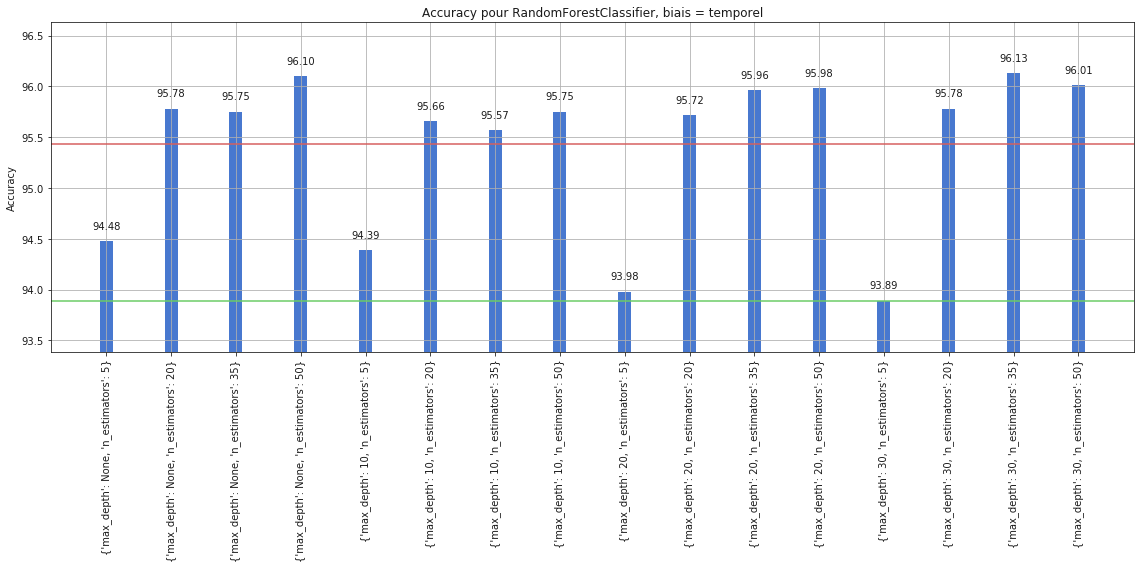

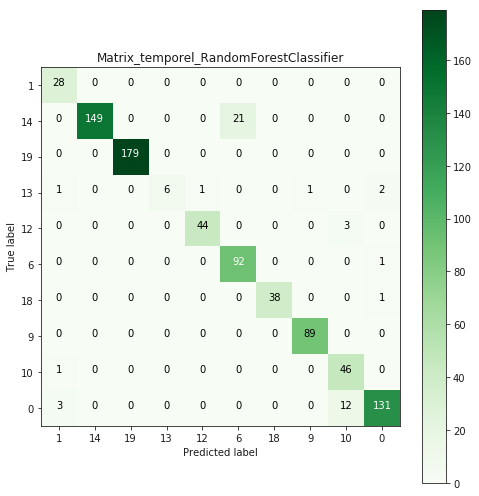

GradientBoostingClassifier 

Score :  94.51 pour {'max_depth': None, 'n_estimators': 5}
Score :  94.72 pour {'max_depth': None, 'n_estimators': 20}
Score :  95.01 pour {'max_depth': None, 'n_estimators': 35}
Score :  95.22 pour {'max_depth': None, 'n_estimators': 50}
Score :  94.33 pour {'max_depth': 10, 'n_estimators': 5}
Score :  94.8 pour {'max_depth': 10, 'n_estimators': 20}
Score :  94.98 pour {'max_depth': 10, 'n_estimators': 35}
Score :  95.28 pour {'max_depth': 10, 'n_estimators': 50}
Score :  94.33 pour {'max_depth': 20, 'n_estimators': 5}
Score :  94.63 pour {'max_depth': 20, 'n_estimators': 20}
Score :  94.92 pour {'max_depth': 20, 'n_estimators': 35}
Score :  95.25 pour {'max_depth': 20, 'n_estimators': 50}
Score :  94.48 pour {'max_depth': 30, 'n_estimators': 5}
Score :  94.63 pour {'max_depth': 30, 'n_estimators': 20}
Score :  95.04 pour {'max_depth': 30, 'n_estimators': 35}
Score :  95.22 pour {'max_depth': 30, 'n_estimators': 50}
Meilleur score :  95.28 pour {'max_depth

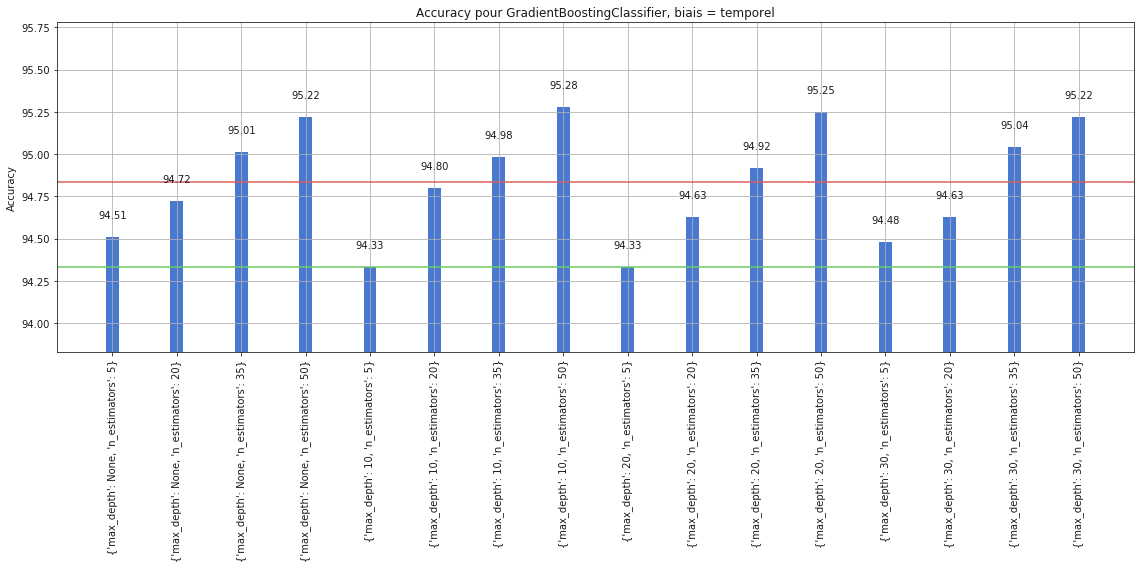

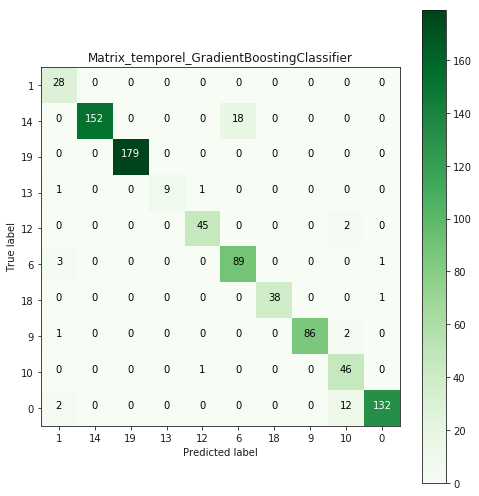

In [13]:
xtrain = data[data['day_of_week'] >= 2]
xtest = data[data['day_of_week'] < 2]
ytrain = xtrain['labels']
ytest = xtest['labels']
del xtrain['labels']
del xtest['labels']

# Recherche d'optimisation
appel_cvs(xtrain, xtest, ytrain, ytest, "temporel")

# Réparition avec data leakage

Il n'y a pas de séparation dans les données entre l'entrainement et les tests

KNeighborsClassifier 

Score :  35.86 pour {'n_neighbors': 5}
Score :  36.66 pour {'n_neighbors': 9}
Score :  38.2 pour {'n_neighbors': 13}
Score :  38.46 pour {'n_neighbors': 17}
Score :  38.24 pour {'n_neighbors': 23}
Score :  38.41 pour {'n_neighbors': 29}
Score :  38.2 pour {'n_neighbors': 37}
Score :  38.01 pour {'n_neighbors': 43}
Score :  38.5 pour {'n_neighbors': 50}
Meilleur score :  38.5 pour {'n_neighbors': 50} 



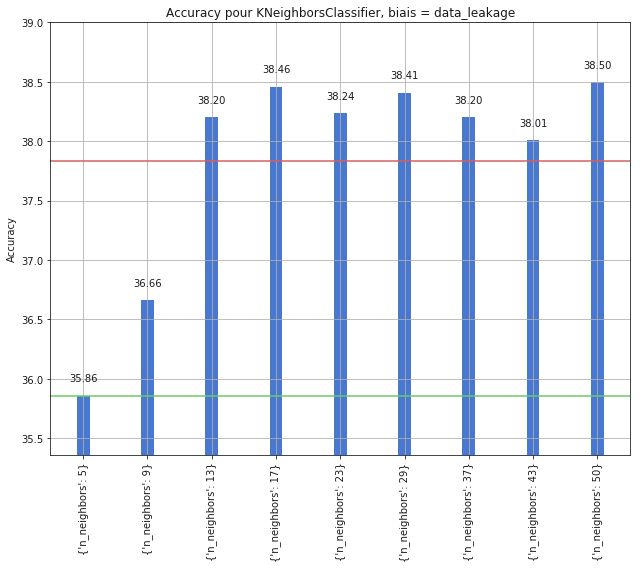

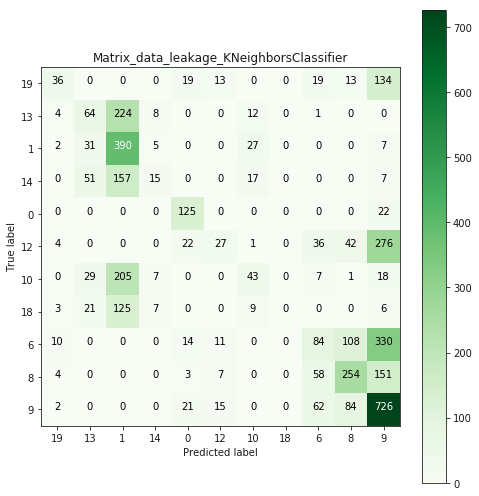

AdaBoostClassifier 

Score :  46.29 pour {'n_estimators': 5}
Score :  46.44 pour {'n_estimators': 20}
Score :  43.51 pour {'n_estimators': 35}
Score :  44.62 pour {'n_estimators': 50}
Score :  41.43 pour {'n_estimators': 65}
Meilleur score :  46.44 pour {'n_estimators': 20} 



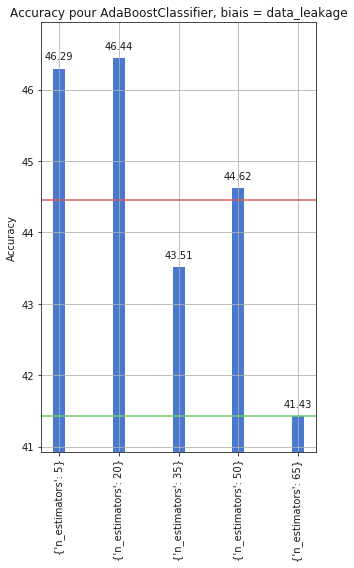

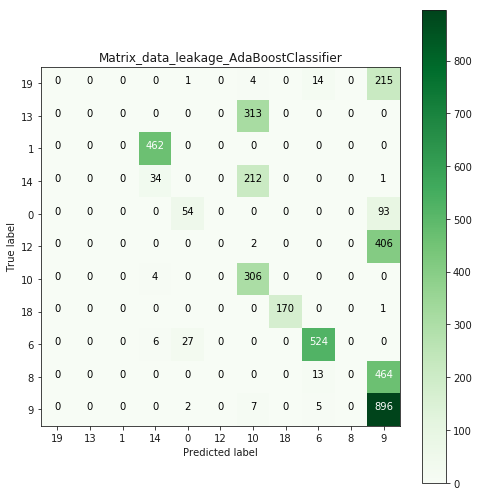

RandomForestClassifier 

Score :  94.33 pour {'max_depth': None, 'n_estimators': 5}
Score :  95.54 pour {'max_depth': None, 'n_estimators': 20}
Score :  96.2 pour {'max_depth': None, 'n_estimators': 35}
Score :  96.06 pour {'max_depth': None, 'n_estimators': 50}
Score :  94.15 pour {'max_depth': 10, 'n_estimators': 5}
Score :  95.28 pour {'max_depth': 10, 'n_estimators': 20}
Score :  95.54 pour {'max_depth': 10, 'n_estimators': 35}
Score :  95.68 pour {'max_depth': 10, 'n_estimators': 50}
Score :  94.59 pour {'max_depth': 20, 'n_estimators': 5}
Score :  95.61 pour {'max_depth': 20, 'n_estimators': 20}
Score :  95.75 pour {'max_depth': 20, 'n_estimators': 35}
Score :  95.99 pour {'max_depth': 20, 'n_estimators': 50}
Score :  94.74 pour {'max_depth': 30, 'n_estimators': 5}
Score :  95.85 pour {'max_depth': 30, 'n_estimators': 20}
Score :  96.08 pour {'max_depth': 30, 'n_estimators': 35}
Score :  96.22 pour {'max_depth': 30, 'n_estimators': 50}
Meilleur score :  96.22 pour {'max_depth': 3

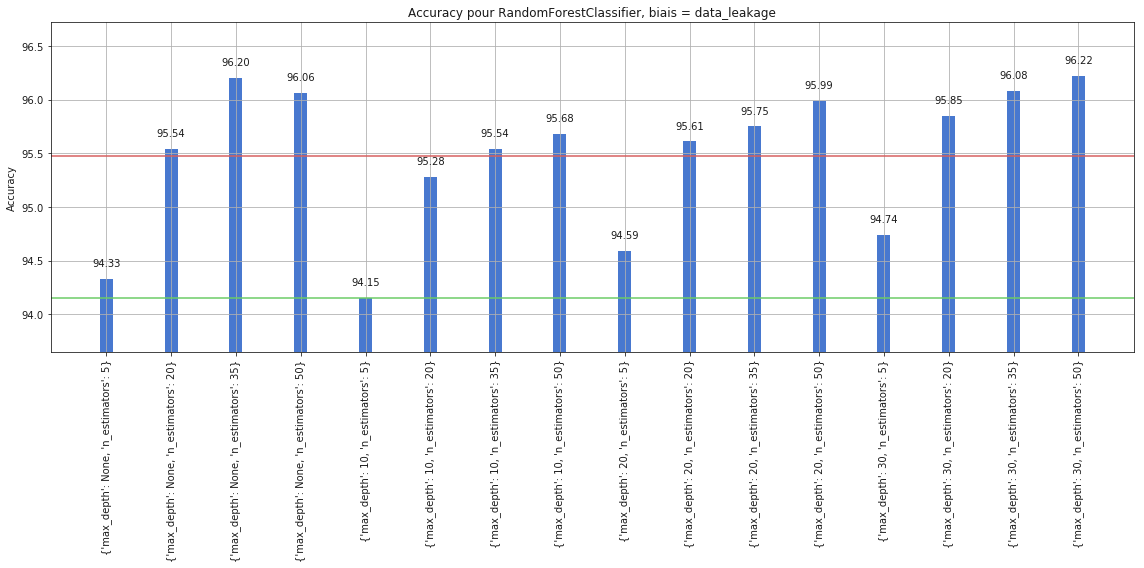

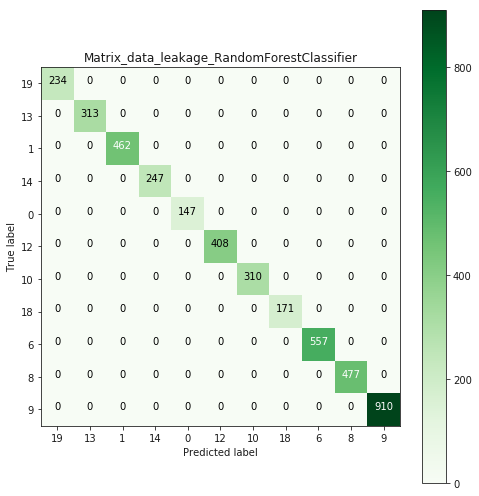

GradientBoostingClassifier 

Score :  95.02 pour {'max_depth': None, 'n_estimators': 5}
Score :  95.25 pour {'max_depth': None, 'n_estimators': 20}
Score :  95.49 pour {'max_depth': None, 'n_estimators': 35}
Score :  95.94 pour {'max_depth': None, 'n_estimators': 50}
Score :  95.25 pour {'max_depth': 10, 'n_estimators': 5}
Score :  95.68 pour {'max_depth': 10, 'n_estimators': 20}
Score :  95.94 pour {'max_depth': 10, 'n_estimators': 35}
Score :  96.29 pour {'max_depth': 10, 'n_estimators': 50}
Score :  95.07 pour {'max_depth': 20, 'n_estimators': 5}
Score :  95.28 pour {'max_depth': 20, 'n_estimators': 20}
Score :  95.63 pour {'max_depth': 20, 'n_estimators': 35}
Score :  95.89 pour {'max_depth': 20, 'n_estimators': 50}
Score :  95.04 pour {'max_depth': 30, 'n_estimators': 5}
Score :  95.18 pour {'max_depth': 30, 'n_estimators': 20}
Score :  95.56 pour {'max_depth': 30, 'n_estimators': 35}
Score :  96.01 pour {'max_depth': 30, 'n_estimators': 50}
Meilleur score :  96.29 pour {'max_dept

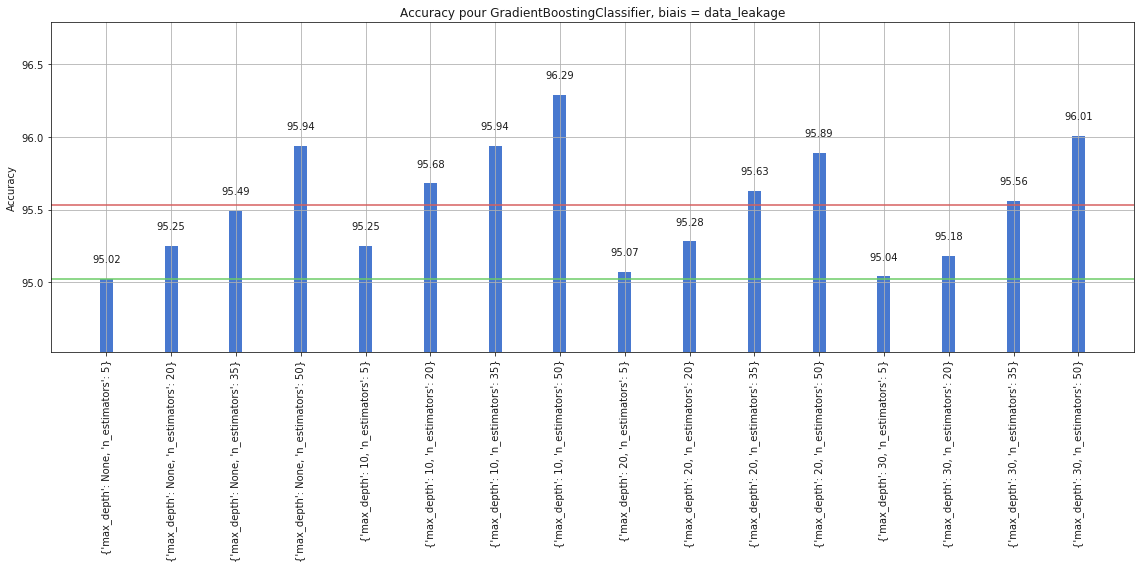

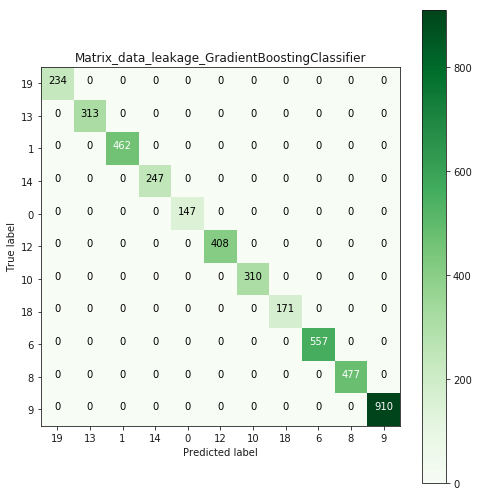

In [14]:
# Recherche d'optimisation
appel_cvs(data_x, data_x, data_y, data_y, "data_leakage")

# Conclusion

La création du biais temporel augmente légèrement l'accuracy des résultats.
De même, la création du biais de data leakage augmente aussi légèremnet l'accuracy des résultats.

Néanmoins, on peut considérer que ce n'est pas une chose à faire car les résultats sont biaisés. Il vaut mieux avoir un vrai taux d'accuracy plus faible plutôt qu'un taux d'accuracy plus fort mais faussé.